# Práctica Spark (Big Data Analytics)
## Análisis Libre

En esta práctica utilizaremos el dataset [HTRU2](https://archive.ics.uci.edu/dataset/372/htru2) de la web [UCI](https://archive.ics.uci.edu).

HTRU2 es un dataset que describe una muestra de candidatos a púlsares recogidas durante la Hight Time Resoluction Universe Survey (HTRU).

Los púlsares son un tipo raro de estrella de neutrones que producen emisiones de radio detectables en La Tierra. Están considerados de interés científico debido a diferentes usos, como por ejemplo, hacer pruebas de espacio-tiempo, estudiar estados de la materia o el medio inter-estelar.

El aprendizaje automático se utiliza para automaticar la detección de candidatos a púlsar facilitando un análisis rápido. Especialmente, se utilizan métodos de clasificación binaria. La clase positiva es una clase minoritaria, por lo que los datos estarán desbalanceados.

El dataset contiene 16,269 ejemplos clasificados como ruido, mientras que 1,639 son ejemplos reales de púlsares. Todos estos ejemplos han sido anotados y revisados por expertos.

Las etiquetas de clase utilizadas son 0 para los ejemplos negativos y 1 para los positivos.

------------------------

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
# fetch dataset
htru2 = fetch_ucirepo(id=372)
# data (as pandas dataframes)
X = htru2.data.features
y = htru2.data.targets
# metadata
print(htru2.metadata)
# variable information
print(htru2.variables)

# Creamos un pandas DataFrame
df = pd.DataFrame(data=X, columns=htru2.feature_names)

# Añadimos la variable objetivo
df['Target'] = y

# Guardamos el dataframe como un csv para poder leerlo con Spark
df.to_csv('htru2.csv', index=False)

{'uci_id': 372, 'name': 'HTRU2', 'repository_url': 'https://archive.ics.uci.edu/dataset/372/htru2', 'data_url': 'https://archive.ics.uci.edu/static/public/372/data.csv', 'abstract': 'Pulsar candidates collected during the HTRU survey. Pulsars are a type of star, of considerable scientific interest. Candidates must be classified in to pulsar and non-pulsar classes to aid discovery.', 'area': 'Physics and Chemistry', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 17898, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C5DK6R', 'creators': ['Robert Lyon'], 'intro_paper': {'ID': 460, 'type': 'NATIVE', 'title': 'Fifty years of pulsar candidate selection: from simple filters to a new principled real-time classification approach', 'a

Inicialización del servidor de Spark  

In [ ]:
from pyspark.sql import SparkSession
# Iniciamos la sesión de Spark
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLlib Lab") \
    .getOrCreate()

sc = spark.sparkContext

from pyspark.ml.feature import VectorAssembler

Leemos el fichero CSV con spark

In [ ]:
df = spark.read.option("header",True).option("delimiter", ",").option("inferSchema",True).csv("htru2.csv")
df.show(5)

+------------+-------------+----------------+----------------+-----------+-----------+-----------+-----------+------+
|Profile_mean|Profile_stdev|Profile_skewness|Profile_kurtosis|    DM_mean|   DM_stdev|DM_skewness|DM_kurtosis|Target|
+------------+-------------+----------------+----------------+-----------+-----------+-----------+-----------+------+
|    140.5625|  55.68378214|    -0.234571412|    -0.699648398|3.199832776|19.11042633|7.975531794|74.24222492|     0|
| 102.5078125|  58.88243001|     0.465318154|    -0.515087909|1.677257525|14.86014572|10.57648674|127.3935796|     0|
|  103.015625|  39.34164944|     0.323328365|     1.051164429|3.121237458|21.74466875|7.735822015|63.17190911|     0|
|      136.75|  57.17844874|    -0.068414638|    -0.636238369|3.642976589| 20.9592803| 6.89649891|53.59366067|     0|
|  88.7265625|  40.67222541|     0.600866079|     1.123491692|1.178929766| 11.4687196|14.26957284|252.5673058|     0|
+------------+-------------+----------------+-----------

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1. Selecciona las columnas que deseas normalizar
feature_columns = [
    "Profile_mean", "Profile_stdev", "Profile_skewness", "Profile_kurtosis",
    "DM_mean", "DM_stdev", "DM_skewness", "DM_kurtosis"
]

# 2. Combina las columnas de características en un vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="inputs")
df_Transformed = assembler.transform(df)

df_Transformed.printSchema()
# Dividimos los datos en entrenamiento y test
trainData, testData = df_Transformed.randomSplit([0.8, 0.2])
trainData.show(5)

# 3. Configura y ajusta el escalador
from pyspark.ml.feature import MinMaxScaler

# Configura MinMaxScaler
minMaxScaler = MinMaxScaler(inputCol="inputs", outputCol="scaledInputs", min=0, max=1)

# Ajusta y transforma los datos
scalerModel = minMaxScaler.fit(trainData)
scaledTrainData = scalerModel.transform(trainData)
scaledTestData = scalerModel.transform(testData)

root
 |-- Profile_mean: double (nullable = true)
 |-- Profile_stdev: double (nullable = true)
 |-- Profile_skewness: double (nullable = true)
 |-- Profile_kurtosis: double (nullable = true)
 |-- DM_mean: double (nullable = true)
 |-- DM_stdev: double (nullable = true)
 |-- DM_skewness: double (nullable = true)
 |-- DM_kurtosis: double (nullable = true)
 |-- Target: integer (nullable = true)
 |-- inputs: vector (nullable = true)

+------------+-------------+----------------+----------------+-----------+-----------+------------+------------+------+--------------------+
|Profile_mean|Profile_stdev|Profile_skewness|Profile_kurtosis|    DM_mean|   DM_stdev| DM_skewness| DM_kurtosis|Target|              inputs|
+------------+-------------+----------------+----------------+-----------+-----------+------------+------------+------+--------------------+
|   6.1796875|  28.37098914|     7.520589491|     57.50455774|174.3461538|58.72705339|-0.730653265|-0.345934684|     1|[6.1796875,28.370...|
|  

In [ ]:
# 6. Verifica el resultado
scaledTrainData.select(["scaledInputs", "Target"]).show(5, truncate=False)
scaledTestData.select(["scaledInputs", "Target"]).show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|scaledInputs                                                                                                                                                    |Target|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[0.0,0.05368631649117565,0.9448061212535328,0.8483827134014019,0.7802391706762296,0.4972957956497691,0.06392444256308585,0.0013672013861189714]                 |1     |
|[4.190412336573919E-5,0.07343687340699058,0.9246530715954342,0.799113320538207,0.7643768591972555,0.631295503795688,0.0610076758211599,0.001250405593667492]    |1     |
|[4.190412336573919E-5,0.0907248730909196,0.8398640869575169,0.6397253605568148,0.6182592667815389,0.4060554018772283,0.09376911271480676,0.0017392988

Una vez tenemos los datos normalizados ya podemos trabajar con ellos

In [ ]:
# Obtenemos el vector de inputs y la clase
trainData_vector = scaledTrainData.select("scaledInputs", "Target")
testData_vector = scaledTestData.select("scaledInputs", "Target")

trainData_vector.show(5)
testData_vector.show(5)

+--------------------+------+
|        scaledInputs|Target|
+--------------------+------+
|[0.0,0.0536863164...|     1|
|[4.19041233657391...|     1|
|[4.19041233657391...|     1|
|[4.60945357023131...|     1|
|[0.00171806905799...|     1|
+--------------------+------+
only showing top 5 rows

+--------------------+------+
|        scaledInputs|Target|
+--------------------+------+
|[-0.0019694937981...|     1|
|[0.00125712370097...|     1|
|[0.00406469996647...|     1|
|[0.00687227623198...|     1|
|[0.01123030506201...|     1|
+--------------------+------+
only showing top 5 rows



## Random Forests

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Función para evaluar un modelo con una semilla específica
def evaluate_model_with_seed(model, seed, trainData_vector, testData_vector, label_col="Target", features_col="scaledInputs"):
    # Configurar el modelo con la semilla
    model.setSeed(seed)

    # Ajustar el modelo
    fitted_model = model.fit(trainData_vector)

    # Predecir las clases
    predictions = fitted_model.transform(testData_vector)

    # Crear el evaluador para las métricas
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    metrics = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]
    results = {metric: evaluator.evaluate(predictions, {evaluator.metricName: metric}) for metric in metrics}

    # Crear la matriz de confusión
    predictions_pd = predictions.select("Target", "prediction").toPandas()
    cm = confusion_matrix(predictions_pd["Target"], predictions_pd["prediction"])
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matriz de Confusión para semilla {seed}")
    plt.show()

    # Calcular AUC
    auc_score = evaluator.evaluate(predictions)
    print(f"AUC: {auc_score}")

    # Generar curva ROC (con pandas y sklearn)
    predictions_pd = predictions.select("Target", "probability").toPandas()

    # Extraer probabilidades de la clase positiva
    predictions_pd["prob_class1"] = predictions_pd["probability"].apply(lambda x: x[1])

    # Crear la curva ROC
    fpr, tpr, thresholds = roc_curve(predictions_pd["Target"], predictions_pd["prob_class1"])
    roc_auc = auc(fpr, tpr)

    # Graficar curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC para semilla {seed}")
    plt.legend(loc="lower right")
    plt.show()

    # Importancia de las características (solo para RandomForest)
    if isinstance(model, RandomForestClassifier):
        importances = fitted_model.featureImportances
    else:
        importances = None

    return importances, results

# Función principal para ejecutar con varias semillas y un modelo
def evaluate_multiple_models_with_seeds(model, seeds, trainData_vector, testData_vector):
    results_list = []
    feature_importances_list = []

    # Ejecutar el modelo para cada semilla
    for seed in seeds:
        importances, result = evaluate_model_with_seed(model, seed, trainData_vector, testData_vector)
        results_list.append(result)
        feature_importances_list.append(importances)

    # Convertir los resultados a DataFrame de pandas
    results_df = pd.DataFrame(results_list)

    # Calcular la media de las métricas
    mean_results = results_df.mean(numeric_only=True)
    print("\nMedia de las métricas:")
    print(mean_results)

    # Mostrar resultados
    print("\nResultados por semilla:")
    print(results_df)

    if isinstance(model, RandomForestClassifier):
      # Mostrar importancia de características
      feature_names = ["Profile_mean", "Profile_stdev", "Profile_skewness", "Profile_kurtosis",
                      "DM_mean", "DM_stdev", "DM_skewness", "DM_kurtosis"]

      # Convertir las importancias a un DataFrame
      feature_importances = pd.DataFrame({
          'feature': feature_names,
          'importance': feature_importances_list[0].toArray()  # Usar el primer conjunto de importancias (todas deberían ser iguales)
      })

      # Ordenar por importancia
      feature_importances = feature_importances.sort_values(by="importance", ascending=False)

      # Graficar importancia de características
      plt.figure(figsize=(10, 6))
      sns.barplot(x='importance', y='feature', data=feature_importances)
      plt.title('Importancia de las Características en el Modelo')
      plt.show()

    return results_df, mean_results

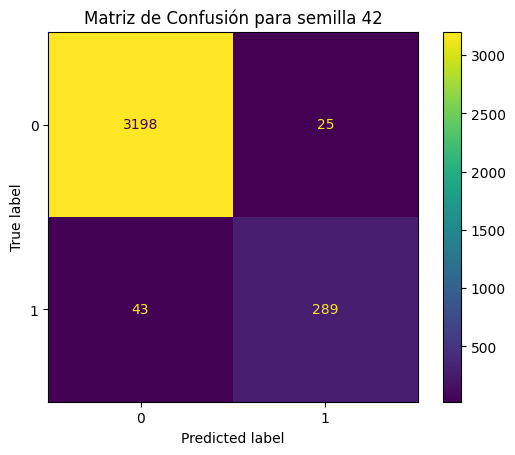

AUC: 0.980632154654506


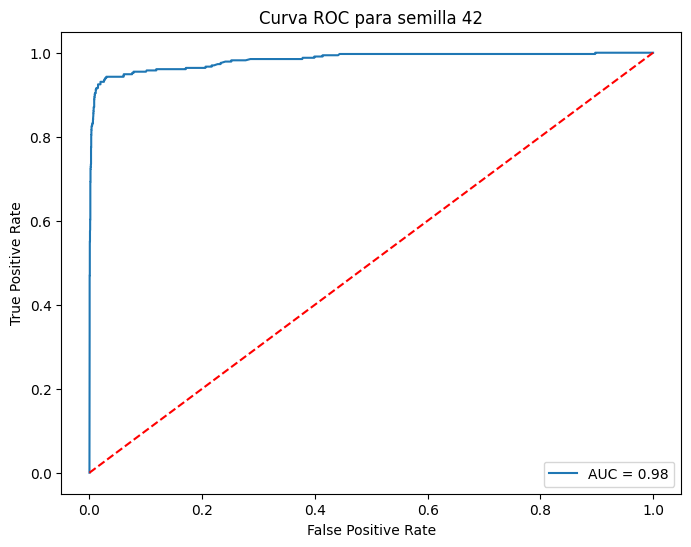

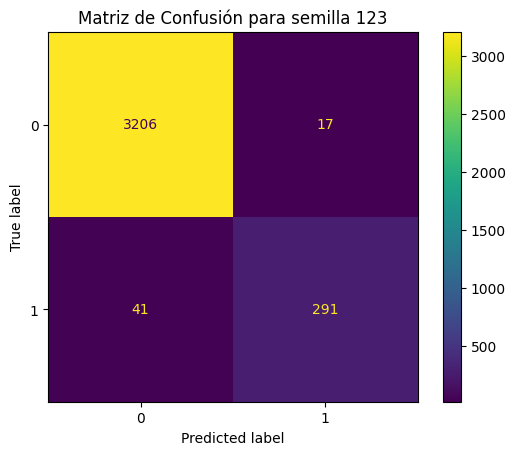

AUC: 0.9834093033518327


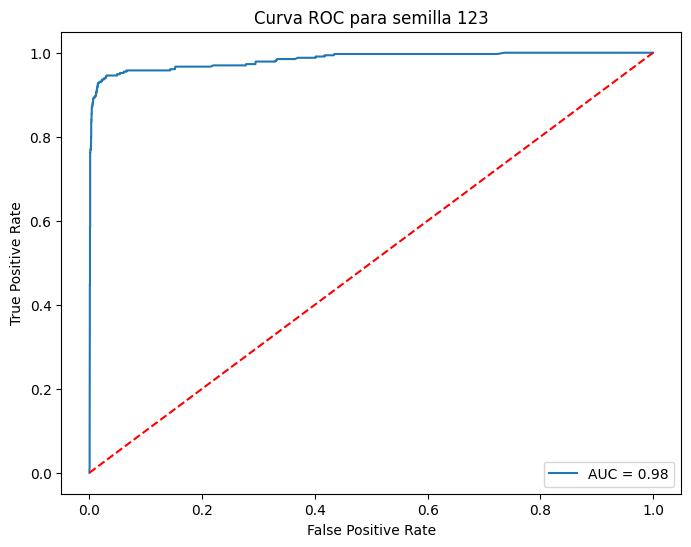

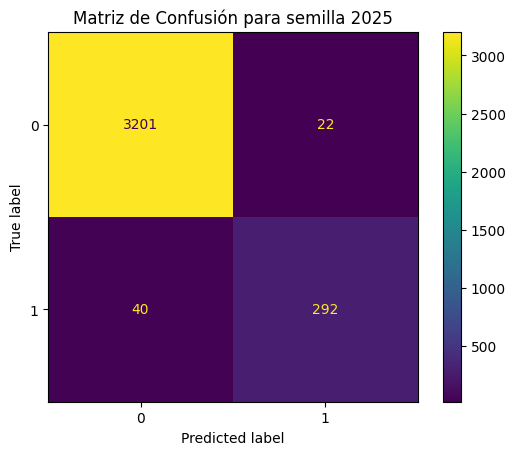

AUC: 0.9823410821849907


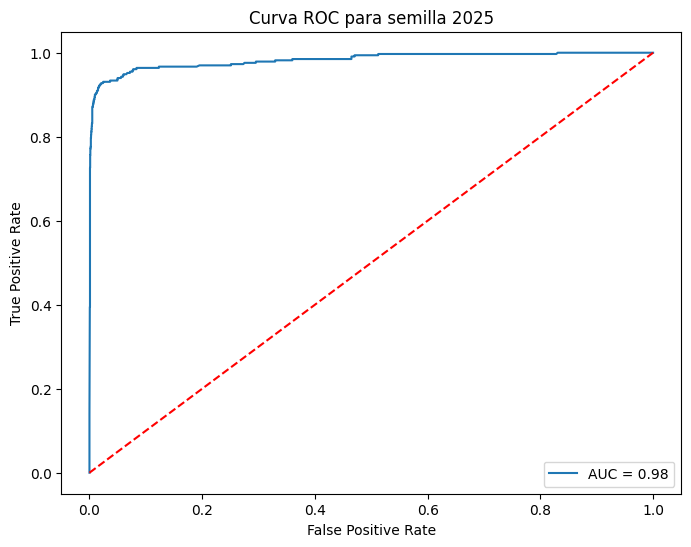


Media de las métricas:
accuracy             0.982372
f1                   0.982128
weightedPrecision    0.982067
weightedRecall       0.982372
dtype: float64

Resultados por semilla:
   accuracy        f1  weightedPrecision  weightedRecall
0  0.980872  0.980632           0.980536        0.980872
1  0.983685  0.983409           0.983398        0.983685
2  0.982560  0.982341           0.982268        0.982560


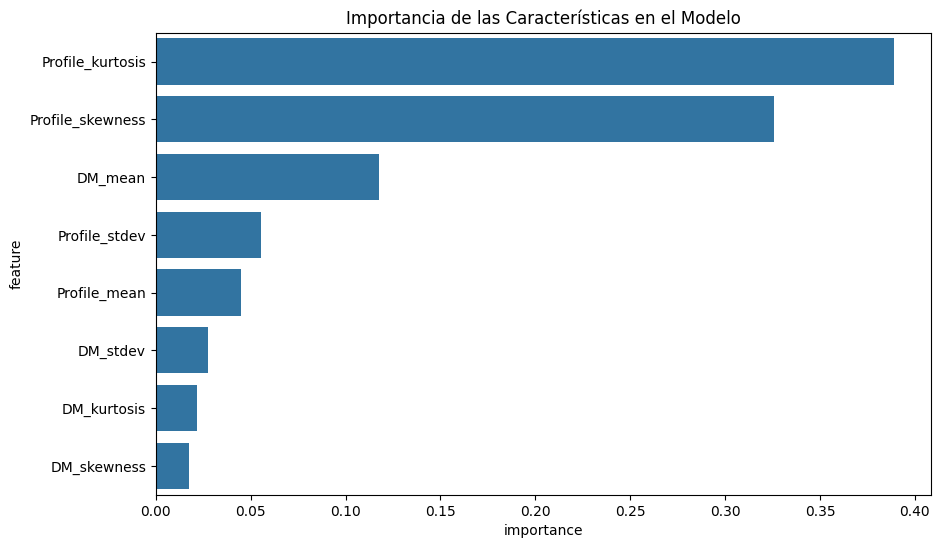

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_model = RandomForestClassifier(numTrees=10, maxDepth=10, labelCol="Target", featuresCol="scaledInputs")
seeds = [42, 123, 2025]
results_df, mean_results = evaluate_multiple_models_with_seeds(rf_model, seeds, trainData_vector, testData_vector)


## Naive Bayes

El modelo de Naive Bayes no acepta valores negativos y, aunque hemos escalado los datos de train entre 0 y 1, los datos de Test pueden moverse hacia valores menores que 0. Por lo que eliminaremos los ejemplos que se hayan salido de la escala.

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import BooleanType

# Crear una función UDF para detectar valores negativos en scaledInputs
def has_negative_values_udf(scaledInputs):
    return any(x < 0 for x in scaledInputs.toArray())

# Registrar la función como UDF
udf_has_negative_values = udf(has_negative_values_udf, BooleanType())

# Detectar filas con valores negativos en los datos de entrenamiento
negative_train_rows = scaledTrainData.filter(udf_has_negative_values(col("scaledInputs")))
print("Filas con valores negativos en los datos de entrenamiento:")
negative_train_rows.show(truncate=False)

# Detectar filas con valores negativos en los datos de test
negative_test_rows = scaledTestData.filter(udf_has_negative_values(col("scaledInputs")))
print("Filas con valores negativos en los datos de test:")
negative_test_rows.show(truncate=False)

# Eliminar filas con valores negativos de los datos de entrenamiento
clean_scaledTrainData = scaledTrainData.filter(~udf_has_negative_values(col("scaledInputs")))

# Eliminar filas con valores negativos de los datos de test
clean_scaledTestData = scaledTestData.filter(~udf_has_negative_values(col("scaledInputs")))

# Verificar que no quedan valores negativos
print("Número de filas con valores negativos después de limpiar los datos:")
print("Train:", clean_scaledTrainData.filter(udf_has_negative_values(col("scaledInputs"))).count())
print("Test:", clean_scaledTestData.filter(udf_has_negative_values(col("scaledInputs"))).count())


Filas con valores negativos en los datos de entrenamiento:
+------------+-------------+----------------+----------------+-------+--------+-----------+-----------+------+------+------------+
|Profile_mean|Profile_stdev|Profile_skewness|Profile_kurtosis|DM_mean|DM_stdev|DM_skewness|DM_kurtosis|Target|inputs|scaledInputs|
+------------+-------------+----------------+----------------+-------+--------+-----------+-----------+------+------+------------+
+------------+-------------+----------------+----------------+-------+--------+-----------+-----------+------+------+------------+

Filas con valores negativos en los datos de test:
+------------+-------------+----------------+----------------+-----------+-----------+-----------+-----------+------+--------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0,
                modelType="multinomial",
                labelCol="Target",      # Columna de etiquetas
                featuresCol="scaledInputs",  # Columna con las características
                )
model = nb.fit(clean_scaledTrainData)

In [ ]:
predictions = model.transform(clean_scaledTestData)
predictions.printSchema()
predictions.show(5)

root
 |-- Profile_mean: double (nullable = true)
 |-- Profile_stdev: double (nullable = true)
 |-- Profile_skewness: double (nullable = true)
 |-- Profile_kurtosis: double (nullable = true)
 |-- DM_mean: double (nullable = true)
 |-- DM_stdev: double (nullable = true)
 |-- DM_skewness: double (nullable = true)
 |-- DM_kurtosis: double (nullable = true)
 |-- Target: integer (nullable = true)
 |-- inputs: vector (nullable = true)
 |-- scaledInputs: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+------------+-------------+----------------+----------------+-----------+-----------+-----------+------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|Profile_mean|Profile_stdev|Profile_skewness|Profile_kurtosis|    DM_mean|   DM_stdev|DM_skewness| DM_kurtosis|Target|              inputs|        scaledInputs|       rawPredicti

### Métricas

accuracy: 0.9209341586944289
f1: 0.8934287004287474
weightedPrecision: 0.9272747698265251
weightedRecall: 0.9209341586944289


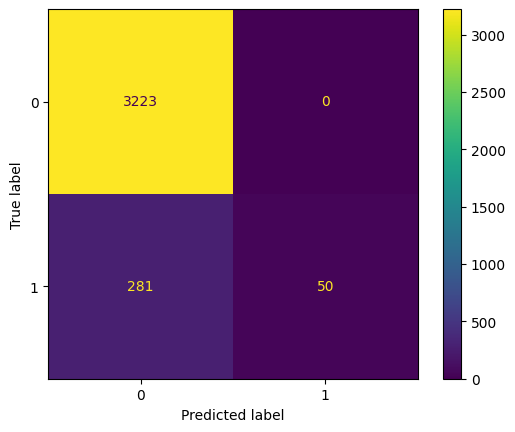

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear el evaluador
evaluator = MulticlassClassificationEvaluator(
    labelCol="Target",           # Columna con las etiquetas reales
    predictionCol="prediction"   # Columna con las predicciones
)

metrics = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]
results = {}

for metric in metrics:
    results[metric] = evaluator.evaluate(predictions, {evaluator.metricName: metric})

for metric, value in results.items():
    print(f"{metric}: {value}")

from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convertir las predicciones a un DataFrame de pandas
predictions_pd = predictions.select("Target", "prediction").toPandas()

# Crear la matriz de confusión
cm = confusion_matrix(predictions_pd["Target"], predictions_pd["prediction"])
ConfusionMatrixDisplay(cm).plot()
plt.show()

AUC: 0.9600670408028401


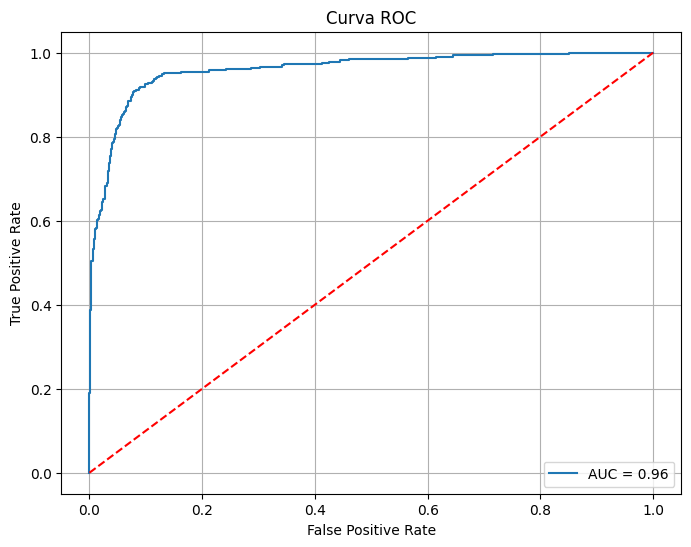

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc

# Evaluador para calcular AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="Target",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)

# Calcular AUC
auc_score = evaluator.evaluate(predictions)
print(f"AUC: {auc_score}")

# Generar curva ROC (con pandas y sklearn)
predictions_pd = predictions.select("Target", "probability").toPandas()

# Extraer probabilidades de la clase positiva
predictions_pd["prob_class1"] = predictions_pd["probability"].apply(lambda x: x[1])

# Crear la curva ROC
fpr, tpr, thresholds = roc_curve(predictions_pd["Target"], predictions_pd["prob_class1"])
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')  # Línea de referencia
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## MultiLayer Perceptron Classifier

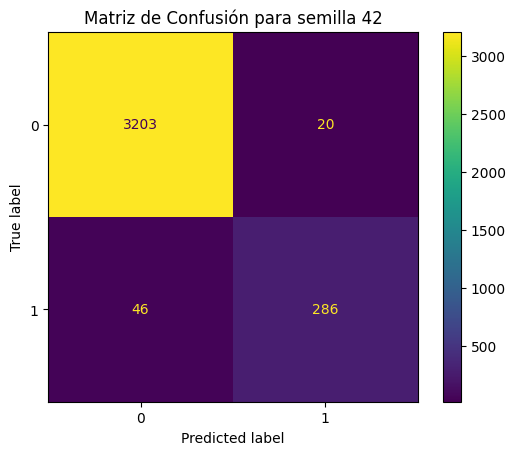

AUC: 0.9810935987311378


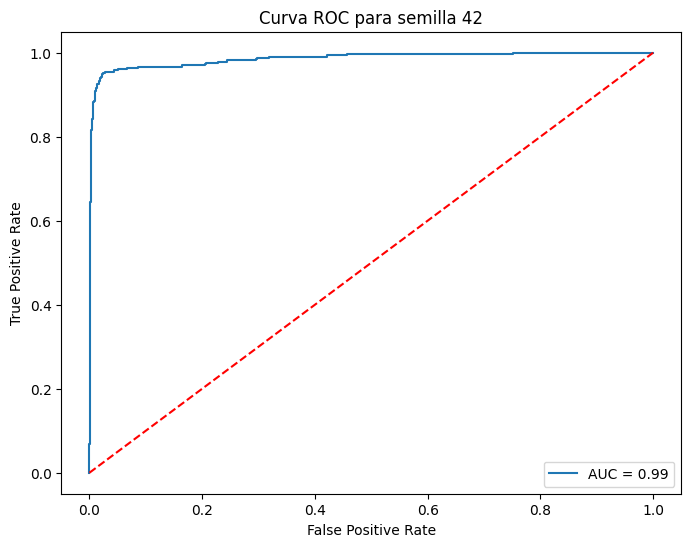

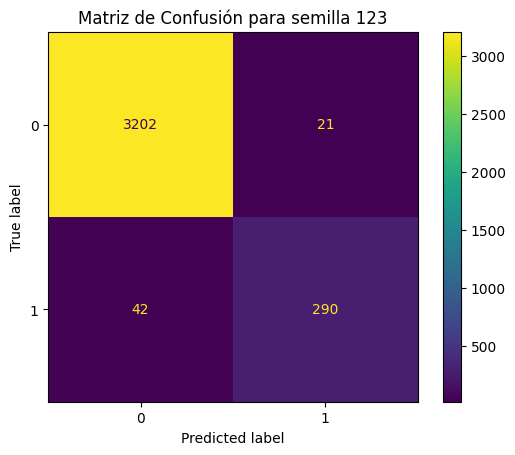

AUC: 0.9820178669923181


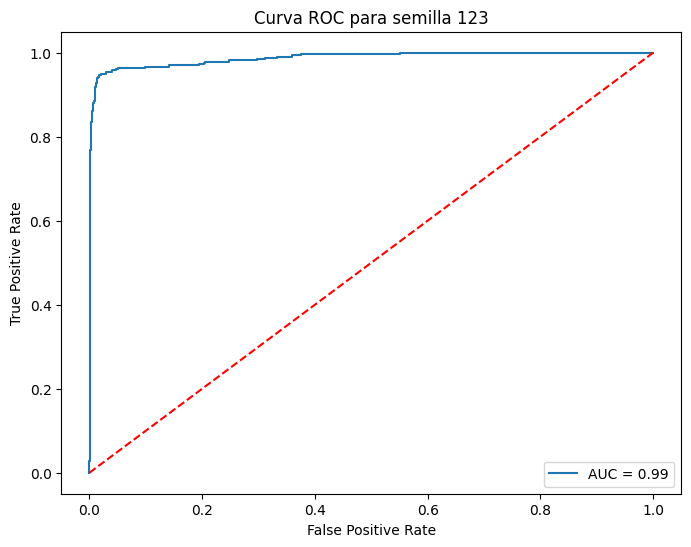

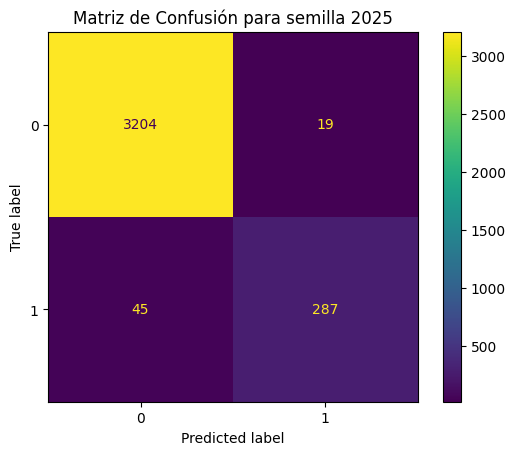

AUC: 0.9816665199817094


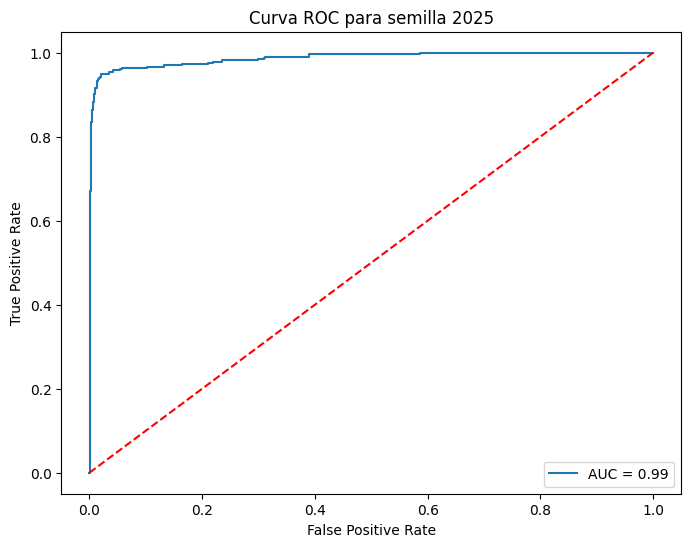


Media de las métricas:
accuracy             0.981903
f1                   0.981593
weightedPrecision    0.981554
weightedRecall       0.981903
dtype: float64

Resultados por semilla:
   accuracy        f1  weightedPrecision  weightedRecall
0  0.981435  0.981094           0.981060        0.981435
1  0.982278  0.982018           0.981956        0.982278
2  0.981997  0.981667           0.981644        0.981997


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

mlp = MultilayerPerceptronClassifier(layers=[8, 2, 2],
                                     maxIter=100,
                                     stepSize=0.001,
                                     featuresCol="scaledInputs",
                                     labelCol="Target")
results_df, mean_results = evaluate_multiple_models_with_seeds(mlp, seeds, trainData_vector, testData_vector)

# Conclusiones

En esta práctica hemos escogido un dataset de una base de datos y hemos utilizado pySpark para entrenar diferentes modelos de clasificación sobre él. Hemos sacado las métricas ejecutadas sobre diferentes semillas y, finalmente, hemos hecho la media para obtener un resultado medio del desempeño de dichos modelos.

Los modelos probados han sido RandomForest, Naive Bayes y, por último, el perceptrón multicapa.

En primer lugar hemos probado el clasificador basado en **Random Forest** utilzando una profundidad de 10 nodos y una cantidad de 10 árboles.

Los resultados que hemos obtenido han sido:

**Media de las métricas**

| Métrica           | Valor   |
|--------------------|---------|
| accuracy           | 0.981903 |
| f1                 | 0.981593 |
| weightedPrecision  | 0.981554 |
| weightedRecall     | 0.981903 |

**Resultados por Semilla**

| Semilla | accuracy | f1       | weightedPrecision | weightedRecall |
|---------|----------|----------|-------------------|----------------|
| 0       | 0.981435 | 0.981094 | 0.981060          | 0.981435       |
| 1       | 0.982278 | 0.982018 | 0.981956          | 0.982278       |
| 2       | 0.981997 | 0.981667 | 0.981644          | 0.981997       |

Podemos observar que las métricas son bastante buenas y consigue unos buenos resultados aún teniendo las clases desbalanceadas.

--------------
En segundo lugar, hemos utilizado el enfoque basado en **Naive Bayes** este modelo no permite utilizar una semilla ya que es determinista, por lo que solo lo hemos ejecutado una vez.

Los resultados han sido:

| Métrica           | Valor   |
|--------------------|---------|
| accuracy           | 0.920934 |
| f1                 | 0.893429 |
| weightedPrecision  | 0.927275 |
| weightedRecall     | 0.920934 |

No son malos resultados, pero son peores que el modelo anterior. Vemos que la métrica de f1 score es más baja que con el RandomForest. Además, si nos fijamos en la matriz de confusión podemos ver que falla con la clase minoritaria ya que este modelo utiliza la probabilidad a priori de pertenecer a una clase, por lo que está sesgado a la clase mayoritaria.

-------------

Por último, utilizaremos el modelo de perceptrón multicapa para clasificar nuestros datos. Utilizaremos una configuración de 8 neuronas en la capa de entrada (los inputs), 2 neuronas en la capa oculta y por último 2 neuronas en la capa de salida (clasificación binaria).

Los resultados del aprendizaje son los siguientes:

**Media de las métricas**

| Métrica           | Valor   |
|-------------------|---------|
| accuracy          | 0.981903 |
| f1                | 0.981593 |
| weightedPrecision | 0.981554 |
| weightedRecall    | 0.981903 |

**Métricas por cada semilla**

| Semilla | accuracy | f1      | weightedPrecision | weightedRecall |
|---------|----------|---------|-------------------|----------------|
| 0       | 0.981435 | 0.981094 | 0.981060          | 0.981435       |
| 1       | 0.982278 | 0.982018 | 0.981956          | 0.982278       |
| 2       | 0.981997 | 0.981667 | 0.981644          | 0.981997       |

Vemos que los resultados mejoras a Naive Bayes y casi que igualan al modelo de RandomForest.

Si nos fijamos en las matrices de confusión del modelo de Random Forest vemos que falla entorno a ~40 ejemplos que clasifica como falsos negativos sin embargo, en el modelo de perceptron multicapa aumenta a ~45.

Aunque tienen un desempeño similar, el modelo de RandomForest es ligeramente superior al de perceptrón multicapa con la configuración elegida. Sin embargo, modificando los hiperparámetros del segundo modelo, podríamos llegar a igualar o superar al modelo de RandomForest.


--------------


Como ampliación de este trabajo, podríamos hacer un estudio sobre los diferentes hiperparámetros de los modelos (número de árboles, profundidad, número de capas ocultas en el perceptrón, número de neuronas, coeficiente de aprendizaje...) utilizando una búsqueda en rejilla (grid search).